### Решать будем задачу бинарной классификации изображений: лес против города

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

2026-01-11 08:09:15.399361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/i.danilov/sandbox/nn_labs/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### Посмотрим на размеры картинок в датасете. Видим, что они одинаковые, так что нам не придется их приводить к единому размеру

In [2]:
from PIL import Image

image = Image.open("labs_data/lab1_2_6/4.Scenes_buildings_vs_forest/buildings/19915.jpg")
print(image.width, image.height)

150 150


### Настроим основные гиперпараметры 

In [3]:
EPOCHS = 20
BATCH_SIZE = 120

NUM_CLASSES = 2


### Загрузим датасет и нормализуем значения пикселей

In [4]:
data_dir = "labs_data/lab1_2_6/4.Scenes_buildings_vs_forest"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=47,
    image_size=(image.height, image.width),
    batch_size=BATCH_SIZE,
    label_mode='binary' 
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=47,
    image_size=(image.height, image.width),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Нормализуем значения пикселей к диапазону [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 4462 files belonging to 2 classes.
Using 3570 files for training.


I0000 00:00:1768108158.294234 3024944 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:21:00.0, compute capability: 7.0


Found 4462 files belonging to 2 classes.
Using 892 files for validation.


### Создадим простенькую модель-классификатор

In [5]:
model = Sequential([
           Input(shape=(image.height, image.width, 3)),
           Conv2D(32, (3, 3), activation='relu'),
           MaxPooling2D((2, 2)),
           Conv2D(64, (3, 3), activation='relu'),
           MaxPooling2D((2, 2)),
           Conv2D(256, (3, 3), activation='relu'),
           Flatten(),
           Dense(40, activation='relu'),

           Dense(1, activation='sigmoid'), 
        ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 295936)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │    11,837,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,004,625 (45.79 MB)

 Trainable params: 12,004,625 (45.79 MB)

 Non-trainable params: 0 (0.00 B)

### Настроим модель для обучения, дополнительно добавив механизм ранней остановки для предотввращения переобучения

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=3e-4),
              metrics=['accuracy'])


# Создание колбэка
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.00001 ,
    restore_best_weights=True
)

### Обучим модель

In [7]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_callback]
                    )

Epoch 1/20


2026-01-11 08:09:21.070832: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f66c4003ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-11 08:09:21.070892: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2026-01-11 08:09:21.213519: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-11 08:09:21.460921: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2026-01-11 08:09:21.709997: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[120,32,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[120,3,150,150]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__c

 7/30 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5092 - loss: 1.0212

I0000 00:00:1768108164.193867 3033729 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6628 - loss: 0.7362

2026-01-11 08:09:25.238545: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[90,32,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[90,3,150,150]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-11 08:09:25.287848: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[90,64,72,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[90,32,74,74]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6671 - loss: 0.7277

2026-01-11 08:09:27.646522: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[120,32,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[120,3,150,150]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-11 08:09:27.705116: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[120,64,72,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[120,32,74,74]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActiv

30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.7924 - loss: 0.4800 - val_accuracy: 0.9103 - val_loss: 0.2294
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9258 - loss: 0.1927 - val_accuracy: 0.9305 - val_loss: 0.1841
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9482 - loss: 0.1475 - val_accuracy: 0.8857 - val_loss: 0.2816
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9440 - loss: 0.1474 - val_accuracy: 0.9585 - val_loss: 0.1238
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9661 - loss: 0.0961 - val_accuracy: 0.9563 - val_loss: 0.1192
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9692 - loss: 0.0889 - val_accuracy: 0.9619 - val_loss: 0.1116
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9798 - loss: 0.0632 - val_accuracy: 0.9518 - val_loss: 0.1416
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9608 - loss: 0.1015 - val_accuracy: 0.9608 - val_loss: 0

### Обратим внимание, что обучение остановилось, так как ошибка на валидационной выборке перестала уменьшаться

### Посмотрим что там по графикам обучения

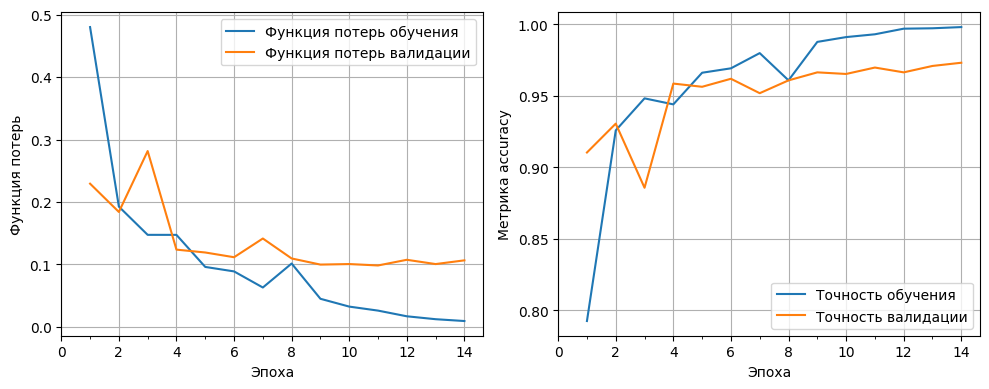

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# Обновляем названия метрик для бинарной классификации
axs[0].plot(np.arange(1, len(history.history["loss"]) + 1), history.history['loss'][:], label='Функция потерь обучения')
axs[0].plot(np.arange(1, len(history.history["loss"]) + 1), history.history['val_loss'][:], label='Функция потерь валидации')
axs[0].grid()
axs[0].set_xticks(np.arange(0, len(history.history["loss"]) + 1, 2))
axs[0].set_xticks(np.arange(0, len(history.history["loss"]) + 1, 1), minor=True)
axs[0].legend(prop={'size': 10})
axs[0].set_xlabel('Эпоха')
axs[0].set_ylabel('Функция потерь')

axs[1].plot(np.arange(1, len(history.history["loss"]) + 1), history.history['accuracy'][:], label='Точность обучения')
axs[1].plot(np.arange(1, len(history.history["loss"]) + 1), history.history['val_accuracy'][:], label='Точность валидации')
axs[1].grid()
axs[1].set_xticks(np.arange(0, len(history.history["loss"]) + 1, 2))
axs[1].set_xticks(np.arange(0, len(history.history["loss"]) + 1, 1), minor=True)
axs[1].legend(prop={'size': 10})
axs[1].set_xlabel('Эпоха')
axs[1].set_ylabel('Метрика accuracy')
plt.tight_layout()
plt.show()

### Потестируем модель

8/8 - 0s - 17ms/step - accuracy: 0.9697 - loss: 0.0984

Точность на валидационном наборе: 96.97%
Функция потерь на валидационном наборе: 0.0984


2026-01-11 08:09:44.189864: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[32,32,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,150,150]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-11 08:09:44.229076: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[32,64,72,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,74,74]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step

2026-01-11 08:09:44.973300: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[24,32,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,150,150]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-11 08:09:44.997435: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[24,64,72,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,32,74,74]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step


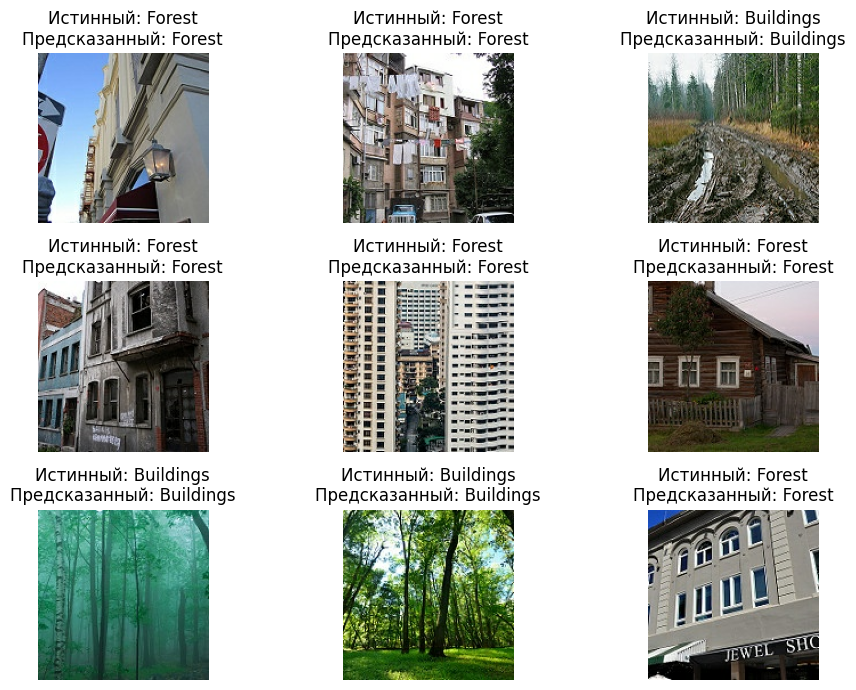

2026-01-11 08:09:45.975585: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
test_loss, test_accuracy = model.evaluate(val_ds, verbose=2)
print(f"\nТочность на валидационном наборе: {test_accuracy*100:.2f}%")
print(f"Функция потерь на валидационном наборе: {test_loss:.4f}")


labels_str = ["Forest", 'Buildings']
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    labels = labels.numpy().astype(int)

    plt.figure(figsize=(10, 7))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Истинный: {labels_str[labels[i][0]]}\nПредсказанный: {labels_str[int(predicted_classes[i])]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


### Видим, что выбранных параметров для сети более чем достаточно для решения оказавшейся простой задачи бинарной классификации данных изображений. 
В целом, оно и неудивительно - признаки здесь явные и в следующих ЛР наверное стоит использовать датасеты посложнее